In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Cyclic

In [2]:
import torch
from cyclic import CyclicGroup

# Some tests to verify our implementation.
c4 = CyclicGroup(order=4)
e, g1, g2, g3 = c4.elements()

assert c4.product(e, g1) == g1 and c4.product(g1, g2) == g3
assert c4.product(g1, c4.inverse(g1)) == e

assert torch.allclose(c4.matrix_representation(e), torch.eye(2))
assert torch.allclose(c4.matrix_representation(g2), torch.tensor([[-1, 0], [0, -1]]).float(), atol=1e-6)

assert torch.allclose(c4.left_action_on_R2(g1, torch.tensor([0., 1.])), torch.tensor([-1., 0.]), atol=1e-7)

In [3]:
# Let's create the group of 90 degree clockwise rotations.
c4 = CyclicGroup(order=4)
e, g1, g2, _ = c4.elements()

# Create a counterclockwise rotation of 270 degrees using only e, g1 and g2.
g3 = c4.product(g1, g2)

assert g3 == c4.elements()[-1]

# Lifting 2d

In [4]:
from lifting import LiftingKernel2d

# Let's check whether our implementation works correctly. First we inspect the
# shape of our transformed grids to assess whether this is correct.
order = 4
lifting2d = LiftingKernel2d(
    group=CyclicGroup(order=order),
    kernel_size=7,
    in_channels=3,
    out_channels=1
)

# The grid has a shape of [2, |H|, kernel_size, kernel_size].
assert lifting2d.transformed_grid_R2.shape == torch.Size([2, 4, 7, 7])

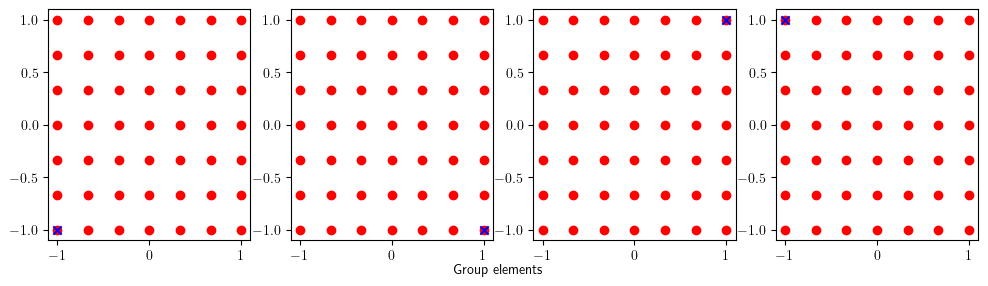

In [5]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures
fig, ax = plt.subplots(1, order)

# Get the grid
transformed_grid_R2 = lifting2d.transformed_grid_R2

# Visualize the transformed kernel grids. We mark the same cornerpoint by a 
# blue 'x' in all grids as reference point.
for group_elem in range(order):
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, :, :],
        transformed_grid_R2[0, group_elem, :, :],
        c='r'
    )
    # Mark a corner point so we can see it transform.
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, 0, 0],
        transformed_grid_R2[0, group_elem, 0, 0],
        marker='x',
        c='b'
    )

fig.text(0.5, 0., 'Group elements', ha='center')
plt.show()

In [6]:
from lifting import InterpolativeLiftingKernel2d

interp_lifting_kernel_2d = InterpolativeLiftingKernel2d(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=2,
    out_channels=1
)

weights = interp_lifting_kernel_2d.sample()
weights.shape

torch.Size([1, 4, 2, 7, 7])

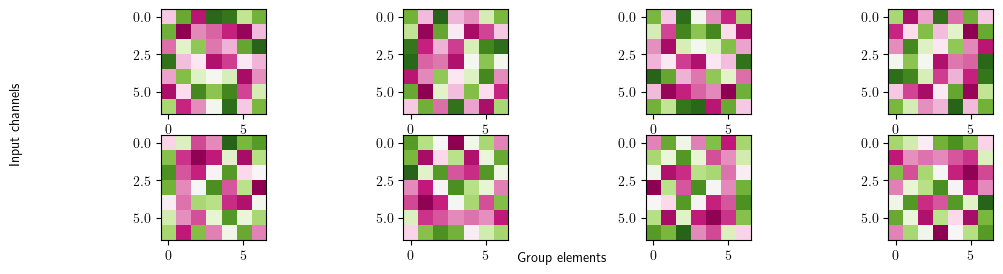

In [7]:
# Pick an output channel to visualize
out_channel_idx = 0

# Create [in_channels, group_elements] figures
fig, ax = plt.subplots(interp_lifting_kernel_2d.in_channels, interp_lifting_kernel_2d.group.elements().numel())

for in_channel in range(interp_lifting_kernel_2d.in_channels):
    for group_elem in range(interp_lifting_kernel_2d.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].detach().numpy(), 
            cmap=plt.cm.PiYG
        )

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels', va='center', rotation='vertical')

plt.show()

In [8]:
from lifting import LiftingConv2d
lifting_conv_2d = LiftingConv2d(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=3,
    out_channels=8,
    padding=False
)

# Group 2d

In [9]:
from group import GroupKernel2d
group_kernel_2d = GroupKernel2d(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=1,
    out_channels=1
)

group_kernel_2d.transformed_grid_R2xH.shape

torch.Size([3, 4, 4, 7, 7])

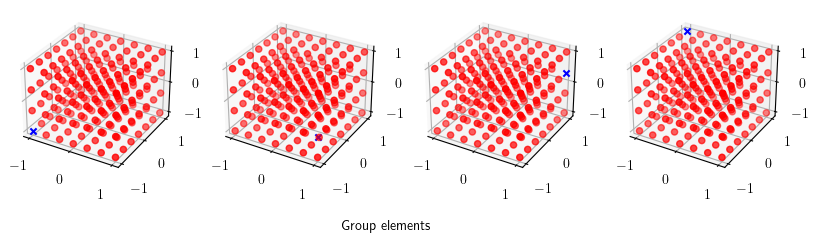

In [10]:
plt.rcParams['figure.figsize'] = [10, 3]

# Create [group_elements] figures.
fig, ax = plt.subplots(
    1,
    group_kernel_2d.group.elements().numel(),
    subplot_kw=dict(projection='3d')
)

# Flatten spatial and group grid dimensions.
transformed_grid_R2xH = group_kernel_2d.transformed_grid_R2xH.reshape(
    3,
    group_kernel_2d.group.elements().numel(),
    group_kernel_2d.group.elements().numel() * group_kernel_2d.kernel_size * group_kernel_2d.kernel_size
)

# Visualize the transformed kernel grids. We mark the same row by a blue 'x' in all grids as reference point.
for group_elem in range(group_kernel_2d.group.elements().numel()):
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 1:],
                           transformed_grid_R2xH[0, group_elem, 1:],
                           transformed_grid_R2xH[2, group_elem, 1:],
                           c='r')
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 0],
                           transformed_grid_R2xH[0, group_elem, 0],
                           transformed_grid_R2xH[2, group_elem, 0],
                           marker='x',
                           c='b')

fig.text(0.5, 0.04, 'Group elements', ha='center')

plt.show()

In [11]:
from group import InterpolativeGroupKernel2d
interp_group_kernel_2d = InterpolativeGroupKernel2d(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=2,
    out_channels=8
)

weights = interp_group_kernel_2d.sample()
weights.shape

torch.Size([8, 4, 2, 4, 5, 5])

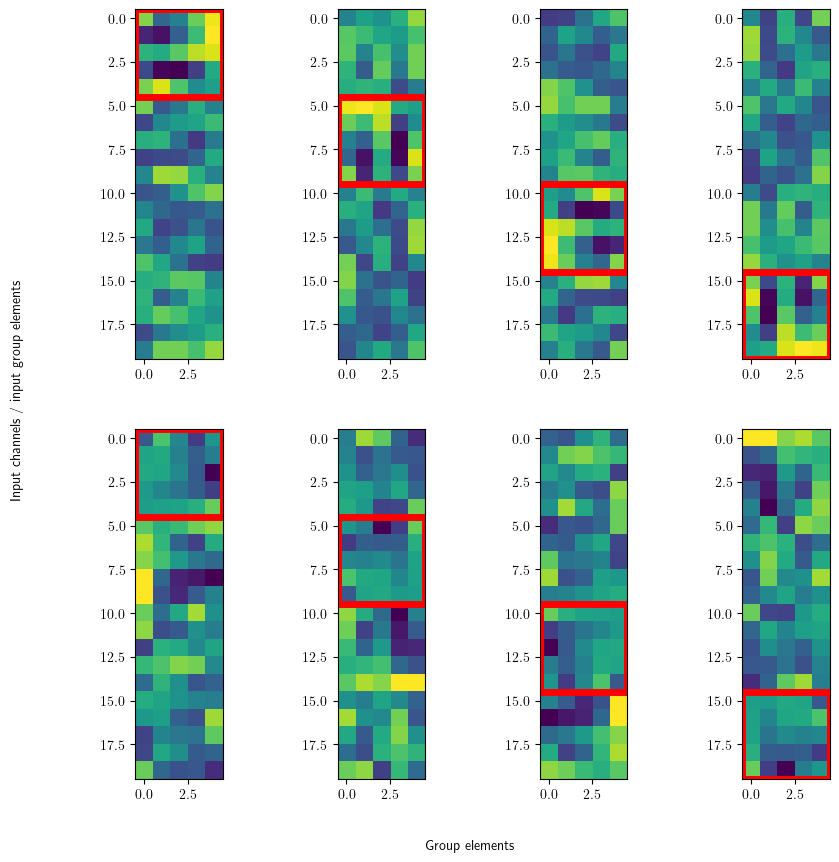

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]

# For ease of viewing, we fold the input group dimension into the spatial x dimension
weights_t = weights.view(
    interp_group_kernel_2d.out_channels,
    interp_group_kernel_2d.group.elements().numel(),
    interp_group_kernel_2d.in_channels,
    interp_group_kernel_2d.group.elements().numel() * interp_group_kernel_2d.kernel_size,
    interp_group_kernel_2d.kernel_size
)

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(interp_group_kernel_2d.in_channels, interp_group_kernel_2d.group.elements().numel())

for in_channel in range(interp_group_kernel_2d.in_channels):
    for group_elem in range(interp_group_kernel_2d.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights_t[out_channel_idx, group_elem, in_channel, :, :].detach()
        )

        # Outline the spatial kernel corresponding to the first group element under canonical transformation
        rect = mpl.patches.Rectangle(
            (-0.5, group_elem * weights_t.shape[-1] - 0.5), weights_t.shape[-1], weights_t.shape[-1], linewidth=5, edgecolor='r', facecolor='none')
        ax[in_channel, group_elem].add_patch(rect)

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels / input group elements', va='center', rotation='vertical')

plt.show()